In [1]:
import numpy as np
import pandas as pd

import os 

import seaborn as sns
import matplotlib.pyplot as plt

import cv2 as cv


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau# , EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_some_fuger(data):
    fig, ax = plt.subplots(4, 4,figsize=(4,4))

    for i in range(4*4):
        row = i //4
        col = i %4
        idx= np.random.choice(len(data))
        image = data[idx]
        ax[row, col].imshow(image,cmap='gray')
        ax[row, col].axis("off")  # Turn off axis labels
   
    plt.show()

In [3]:
def extract_data_from_generator(generator):
    num_samples = len(generator.filenames)
    x_train, y_train = [], []
    for _ in range(num_samples // generator.batch_size):
        x_batch, y_batch = generator.next()
        x_train.extend(x_batch)
        y_train.extend(y_batch)

    return np.array(x_train) , np.array(y_train)


In [4]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    rescale=1.0/255, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [5]:
train_generator = data_generator.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=(48, 48),
    color_mode='grayscale',
    shuffle=True,
    class_mode='sparse', 
    batch_size=60,
    subset='training', 
    classes=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
    seed=42  
)

validation_data = data_generator.flow_from_directory(
    '/kaggle/input/fer2013/test',
    target_size=(48, 48),
    color_mode='grayscale', 
    shuffle=True,
    batch_size=60,
    class_mode='sparse', 
    classes=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
    seed=42 
)


Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [6]:
x ,y = extract_data_from_generator(train_generator)
y =y.astype(int)

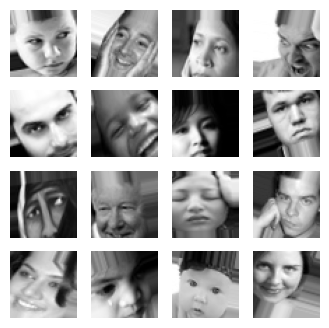

In [7]:
plot_some_fuger(x)

In [8]:
x.shape ,y.shape

((28260, 48, 48, 1), (28260,))

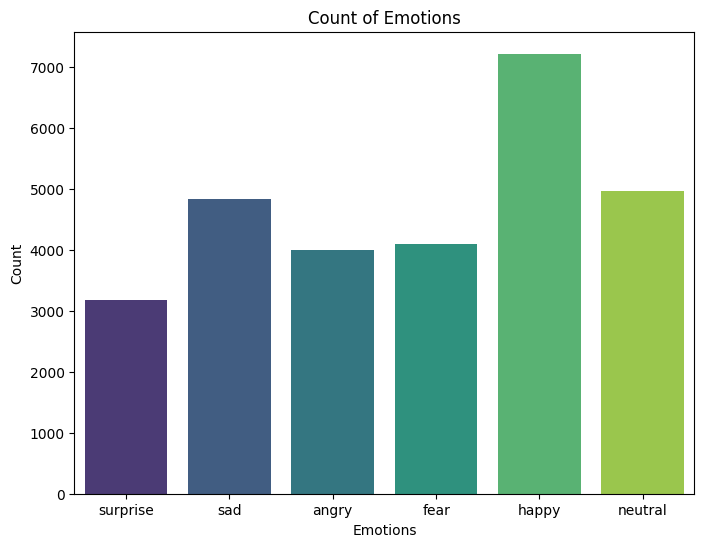

In [9]:

def assign_emotions(arr):
    classes = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    emotions = [classes[val] for val in arr]
    return emotions

# Example array
np_array =y
# Assign emotions
emotions = assign_emotions(np_array)

# Convert emotions to a Pandas Series
emotions_series = pd.Series(emotions)

# Create a count plot using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x=emotions_series, palette='viridis')
plt.title('Count of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()


In [41]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(48, 48, 1))) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(6, activation = "softmax"))


In [42]:
model.compile(optimizer=  Adam(lr = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
epochs = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.0001)

checkpoint = ModelCheckpoint("fer_model.h5", monitor='val_loss', 
                             mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr,]



In [44]:
history = model.fit_generator(train_generator   , validation_data=validation_data , callbacks=callbacks, epochs = epochs )

Epoch 1/50


/tmp/ipykernel_80/4049100600.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator   , validation_data=validation_data , callbacks=callbacks, epochs = epochs )
2023-12-26 01:36:43.732860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


472/472 [==============================] - ETA: 0s - loss: 1.8661 - accuracy: 0.2276
Epoch 1: saving model to fer_model.h5
472/472 [==============================] - 77s 153ms/step - loss: 1.8661 - accuracy: 0.2276 - val_loss: 1.7918 - val_accuracy: 0.2522 - lr: 0.0010
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/472 [==============================] - ETA: 0s - loss: 1.7580 - accuracy: 0.2615
Epoch 2: saving model to fer_model.h5
472/472 [==============================] - 47s 100ms/step - loss: 1.7580 - accuracy: 0.2615 - val_loss: 1.7867 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 3/50
472/472 [==============================] - ETA: 0s - loss: 1.6236 - accuracy: 0.3368
Epoch 3: saving model to fer_model.h5
472/472 [==============================] - 47s 101ms/step - loss: 1.6236 - accuracy: 0.3368 - val_loss: 1.9853 - val_accuracy: 0.2115 - lr: 0.0010
Epoch 4/50
472/472 [==============================] - ETA: 0s - loss: 1.4869 - accuracy: 0.4064
Epoch 4: saving model to fer_model.h5
472/472 [==============================] - 48s 103ms/step - loss: 1.4869 - accuracy: 0.4064 - val_loss: 1.5243 - val_accuracy: 0.3719 - lr: 0.0010
Epoch 5/50
472/472 [==============================] - ETA: 0s - loss: 1.3910 - accuracy: 0.4523
Epoch 5: saving model to fer_model.h5
472/472 [=========================

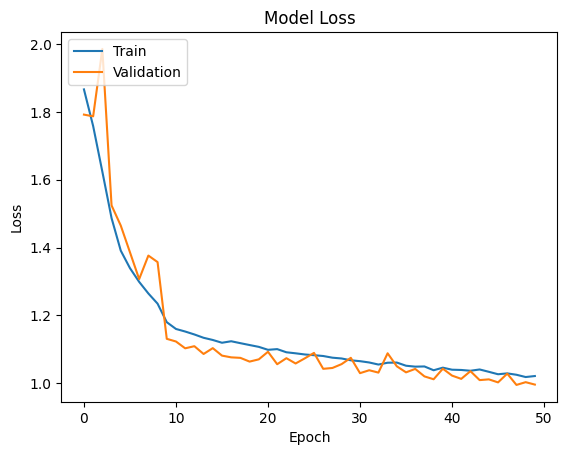

In [53]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

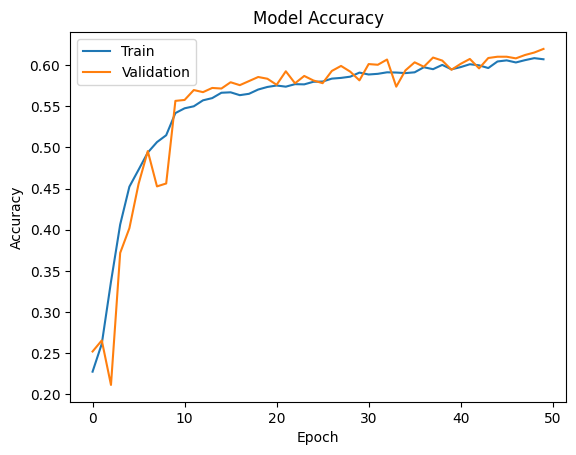

In [54]:
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# testing data

In [47]:
xtest ,ytest = extract_data_from_generator(validation_data)

In [55]:
from sklearn.metrics import confusion_matrix ,ConfusionMatrixDisplay,classification_report

In [56]:
y_pred=model.predict(xtest)
ls=[]
for i in y_pred:
    ls.append(i.argmax())
y_pred=np.array(ls)

219/219 [==============================] - 1s 3ms/step


In [57]:
print(classification_report(ytest,y_pred,target_names=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']))

              precision    recall  f1-score   support

       angry       0.54      0.53      0.54       953
        fear       0.46      0.22      0.30      1015
       happy       0.82      0.86      0.84      1759
     neutral       0.57      0.59      0.58      1222
         sad       0.46      0.61      0.52      1237
    surprise       0.72      0.75      0.74       821

    accuracy                           0.62      7007
   macro avg       0.60      0.59      0.58      7007
weighted avg       0.61      0.62      0.61      7007



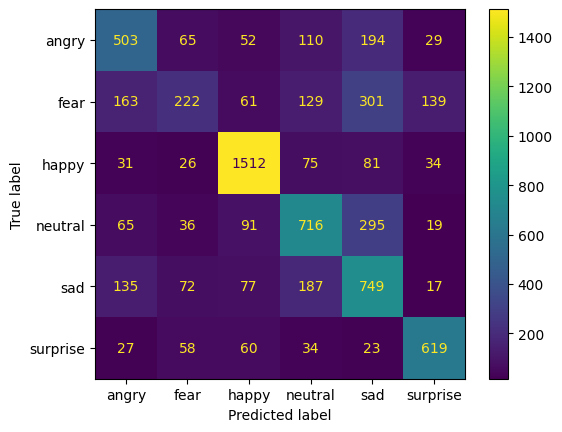

In [58]:
ConfusionMatrixDisplay (confusion_matrix(ytest, y_pred),display_labels=['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']).plot()


In [59]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()

# Load the JSON file
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [60]:
model.save_weights('wighet.h5')